<a href="https://colab.research.google.com/github/serciex/lane-change/blob/main/V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing Prerequisites

In [12]:
!pip install pygame
!pip install highway-env

Testing

In [13]:
#Import Libraries
from os import truncate
import math
import gymnasium
import highway_env
from matplotlib import pyplot as plt
import pygame
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
import gym
from random import randint
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from collections import deque
import random
import torch.optim as optim
import tqdm

# Workaround for gym compatibility
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

%matplotlib inline

Environment Definition

In [14]:
# Configure Environment Conditions
config = {
    "lanes_count": 3,
    "lane_width": 3.75,
    "observation": {
        "type": "Kinematics",
        "features": ["x", "y", "vx", "vy", "heading", "lat_off"]
    },
    "action": {"type": "ContinuousAction"},"ego_spawn_random": True,
    "policy_frequency": 10,
}
env = gymnasium.make('highway-v0', render_mode='rgb_array', config=config)
frames = []

# Action Setup
highway_env.envs.common.action.ContinuousAction(env, lateral=True,
                                                longitudinal=True)

IDM Controller

In [15]:
# Environment Manager
class ENV(env.__class__):
  """
  s = (v,a,x,y,thetha,id,w,c) ∈ S

  Lateral Agent State:
  Obs Data:
  x = vehicle x position (x)
  y = vehicle y position (y)
  v = vehicle speed (vx)
  thetha = yaw angle (heading)

  Input:
  a = longitudinal acceleration (longitudinal_control)
  id = target lane id
  w = lane width
  c = road curvature

  Extra Data:
  vy = lateral rate (vy)
  delta_lat_deviation = change in lateral deviation (lat_off)

  """
  def __init__(self, obs, desired_parameters, control_parameters):
    self.obs = obs
    # Unpack initial parameters: [s0, v0]
    self.s0, self.v0 = desired_parameters

    # Unpack control parameters: [a, b, delta, T]
    self.a, self.b, self.delta, self.T = control_parameters

  def ego_state_idm(self):
      ax, ay, avx, avy, athetha, _ = self.obs[0]
      self._ego_state_idm = {"x": ax, "y": ay, "vx": avx,"thetha": athetha,
                         "longitudinal_acceleration":self.a}

      return self._ego_state_idm

  def update(self,obs):
    self.obs = obs

  def ego_state_agent(self,target_id):
      ax, ay, avx, avy, athetha, _ = self.obs[0]
      vehicle = env.unwrapped.vehicle

      # Control Parameters
      self.id = target_id

      # Environment Parameters
      self.s,_ = vehicle.lane.local_coordinates(vehicle.position)
      self.w = vehicle.lane.width
      self.c = vehicle.lane.heading_at(np.clip(
          vehicle.lane.local_coordinates(vehicle.position)[0],
          0, vehicle.lane.length))
      self.v = math.sqrt(avx**2+avy**2)

      self._ego_state_agent = {"x": ax, "y": ay, "vx": self.v,"thetha": athetha,
                         "lane_width":self.w,"lane_id":self.id,
                         "self_curvature":self.c,
                         "longitudinal_acceleration":self.a}

      return self._ego_state_agent

  def longitudinal_lead_state(self):
      # Lead State Parameters on the same Lane (5 columns: presence, x, y, vx, vy)
      ego_vehicle = env.unwrapped.vehicle
      lead_vehicle = env.unwrapped.road.neighbour_vehicles(ego_vehicle, lane_index=ego_vehicle.lane_index)[0]

      if lead_vehicle:
          gap = lead_vehicle.position[0] - ego_vehicle.position[0]
          delta_velocity = ego_vehicle.velocity[0] - lead_vehicle.velocity[0]
          self._longitudinal_lead_state = {"x": gap, "vx": delta_velocity}
      else:
          self._longitudinal_lead_state = {"x": 10, "vx": 0}

      return self._longitudinal_lead_state

  def idm_controller(self):
      # Unpack input variables: [s, v, delta_v]
      s, v, delta_v = self.longitudinal_lead_state()['x'], self.ego_state_idm()['vx'], self.longitudinal_lead_state()['vx']

      # Small epsilon to account for very small gaps and avoid division by zero
      epsilon = 1e-6

      # Desired gap: s* = s0 + v*T + (v * delta_v) / (2 * sqrt(a * b))
      desired_gap = self.s0 + max(0, v * self.T + ((v * delta_v) / (2 * math.sqrt(self.a * self.b))))

      # IDM acceleration: a_IDM = a * [ 1 - (v / v0)^delta - (s* / s)^2 ]
      acceleration = self.a * (1 - (v / self.v0)**self.delta - (desired_gap / (s + epsilon))**2)

      return acceleration


  #Reward Function
  def reward_function(self, obs_old, obs_new, target_id, w1=1, w2=1, w3=0.05):
    """
    Reward Function:

    Acceleration Reward: r_acce = w1*f_acce(a_yaw)
    a_yaw = yaw acceleration (rate of change of yaw rate)

    Rate Reward: r_rate = w2*f_rate(w_yaw)
    w_yaw = yaw rate (rate of change of heading)

    Time Reward: r_time = w3*f_time (delta_lat_deviation)
    delta_lat_deviation = change in lateral deviation (self.lat_off)

    Reward = Cummulative Sum of r_acce + Cummulative Sum of r_rate + Cummulative Sum of r_time

    """

    # Use current vehicle lane structure and only change the lane ID
    current_lane_index = list(env.unwrapped.vehicle.lane_index)
    current_lane_index[2] = target_id  # Only change the lane number
    self.target_id = tuple(current_lane_index)

    target_lane_object = env.unwrapped.road.network.get_lane(self.target_id)
    vehicle_s, _ = env.unwrapped.vehicle.lane.local_coordinates(env.unwrapped.vehicle.position)
    _ , self.delta_lat_deviaton = target_lane_object.local_coordinates(env.unwrapped.vehicle.position)

    obs = obs_new[0]
    obs_old = obs_old[0]

    # Calculate yaw rates from heading changes
    current_yaw_rate = (obs[4] - obs_old[4]) * env.unwrapped.config['policy_frequency']

    # Store/retrieve previous yaw rate
    if not hasattr(self, 'previous_yaw_rate'):
        self.previous_yaw_rate = 0

    w_yaw = current_yaw_rate
    w_yaw_old = self.previous_yaw_rate

    # Update stored value for next iteration
    self.previous_yaw_rate = current_yaw_rate

    self.w_acce = (w_yaw-w_yaw_old)*env.unwrapped.config['policy_frequency']

    # Acceleration Reward
    acce_reward = -1*abs(self.w_acce)

    # Rate Reward
    rate_reward = -1*abs(w_yaw)

    # Time Reward
    time_reward = -0.05 * abs(self.delta_lat_deviaton)

    # Overall Reward
    self.reward = w1*acce_reward + w2*rate_reward + w3*time_reward

    return [self.reward, acce_reward, rate_reward, time_reward]

  def action(self, obs, lateral_action):
      self.obs = obs
      L = env.unwrapped.vehicle.LENGTH
      self.acc = self.idm_controller()

      # Calculate steering angle from lateral acceleration
      self.angle = math.atan(L * lateral_action / self.ego_state_idm()['vx']**2)

      # Return the action as [longitudinal_acceleration, steering_angle]
      calculated_action = [self.acc, self.angle]

      return calculated_action

Agent Defintion

In [16]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim=8, action_dim=1, hidden_size=128):
        super().__init__()
        self.action_dim = action_dim

        # Policy head (actor) - Output 2 values: mean and log_std
        self.actor = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, self.action_dim * 2),  # Use self.action_dim here
        )

        # Value head (critic)
        self.critic = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        # Value head
        value = self.critic(x)

        # Policy head
        actor_output = self.actor(x)
        action_mean, action_log_std = torch.split(actor_output, self.action_dim, dim=-1) # Split output

        action_std = torch.exp(action_log_std)
        action_dist = torch.distributions.Normal(action_mean, action_std)

        return action_dist, value

    def action(self, state, deterministic = False):
        action_dist, value = self.forward(state)

        if deterministic:
            action = action_dist.mean
            log_prob = action_dist.log_prob(action)

        else:
          action = action_dist.sample()
          log_prob = action_dist.log_prob(action)

        return action, log_prob, value

Lateral Controller (Gap Checker)

In [17]:
import numpy as np

class Gap_Controller(env.__class__):
    def __init__(self, obs=None, following_gap_threshold=10.0):
        # Optionally store an initial observation if provided.
        if obs is not None:
            self.obs = obs
        # Threshold for safety gap with the following vehicle
        self.following_gap_threshold = following_gap_threshold

    def lane_checker(self):
        """
        Determines which adjacent lane offers the safest gap for a lane change.
        It examines the current lane, the lane to the left, and the lane to the right,
        returning the lane index that has the largest safe front gap available.
        In addition, if the gap with the following vehicle in the target lane is below the safety
        threshold, the lane change is aborted and the current lane is chosen.

        Returns:
            int: The target lane index (the lane with the largest safe gap, or the current lane)
                 if the candidate lane's following vehicle gap is unsafe.
        """
        lane_number = len(env.unwrapped.road.network.lanes_list())
        ego = env.unwrapped.vehicle

        # Initialize front gap values with a default that indicates an unsafe or non-existent gap.
        gap_current_front = -float('inf')
        gap_right_front = -float('inf')
        gap_left_front = -float('inf')

        # Initialize following gap values (gap between ego and the vehicle behind)
        gap_current_follower = float('inf')
        gap_right_follower = float('inf')
        gap_left_follower = float('inf')

        # Get vehicle neighbours in current lane:
        neighbours_current = env.unwrapped.road.neighbour_vehicles(ego, ego.lane_index)
        # neighbours_current[0] is the vehicle ahead and [1] is the following vehicle.
        if neighbours_current:
            if neighbours_current[0]:
                gap_current_front = neighbours_current[0].position[0] - ego.position[0]
            if len(neighbours_current) > 1 and neighbours_current[1]:
                gap_current_follower = ego.position[0] - neighbours_current[1].position[0]

        # Compute the left and right lane indices.
        current_lane = list(ego.lane_index)
        if current_lane[2] > 0:
            lane_left = (current_lane[0], current_lane[1], current_lane[2] - 1)
        else:
            lane_left = ego.lane_index

        if current_lane[2] < (lane_number - 1):
            lane_right = (current_lane[0], current_lane[1], current_lane[2] + 1)
        else:
            lane_right = ego.lane_index

        # Retrieve neighbour vehicles for the right lane.
        neighbours_right = env.unwrapped.road.neighbour_vehicles(ego, lane_index=lane_right)
        if neighbours_right:
            if neighbours_right[0]:
                gap_right_front = neighbours_right[0].position[0] - ego.position[0]
            if len(neighbours_right) > 1 and neighbours_right[1]:
                gap_right_follower = ego.position[0] - neighbours_right[1].position[0]

        # Retrieve neighbour vehicles for the left lane.
        neighbours_left = env.unwrapped.road.neighbour_vehicles(ego, lane_index=lane_left)
        if neighbours_left:
            if neighbours_left[0]:
                gap_left_front = neighbours_left[0].position[0] - ego.position[0]
            if len(neighbours_left) > 1 and neighbours_left[1]:
                gap_left_follower = ego.position[0] - neighbours_left[1].position[0]

        # Compare the front gaps: current, right, and left.
        front_gaps = [gap_current_front, gap_right_front, gap_left_front]
        best_index = np.argmax(front_gaps)

        # Determine the target lane index based on the best candidate.
        # best_index: 0 => current lane, 1 => right lane, 2 => left lane.
        if best_index == 1:
            candidate_lane = lane_right
            candidate_follower_gap = gap_right_follower
        elif best_index == 2:
            candidate_lane = lane_left
            candidate_follower_gap = gap_left_follower
        else:
            candidate_lane = ego.lane_index
            candidate_follower_gap = gap_current_follower  # in current lane, we don't enforce follower gap condition

        # Check if the candidate lane (if different from the current lane)
        # meets the follower gap condition.
        if candidate_lane != ego.lane_index:
            if candidate_follower_gap < self.following_gap_threshold:
                # The follower gap is too small; do not change lanes.
                target_lane_id = ego.lane_index[2]
            else:
                target_lane_id = candidate_lane[2]
        else:
            target_lane_id = ego.lane_index[2]

        return target_lane_id


Initialize Environment

In [18]:
# Initialize Environment
obs, _ = env.reset()
# IDM Initialization
control_parameters = [0.1, 5, 4, 4]  # a, b, δ, T
desired_parameters = [20, 10.0]       # s0, v0

# Initialize Environment Manager and Reward
state_manager = ENV(obs,control_parameters=control_parameters,desired_parameters=desired_parameters)

# State Manager for Ego and Lead State
ego_state_idm = state_manager.ego_state_idm()
lead_state = state_manager.longitudinal_lead_state()

Training Loop

Always Active (Option 1)

In [19]:
################################################################################
"""Initialization"""
################################################################################

# Agent Initialization
total_steps_taken = 0
lr = 0.01  # Reduced learning rate
gamma = 0.99  # Higher discount factor for better long-term rewards
action_dim = 1  # Lateral acceleration

# Reasonable hyperparameter sizes
buffer_size = int(1e5)  # 100k buffer
batch_size = 256  # Standard batch size
max_timesteps = int(4e4)  # 40k total timesteps

plot_freq_steps = 5000  # Plot every 5000 timesteps

# Epsilon-Greedy Parameters
epsilon = 0.3

# Tracking for performance
timestep_rewards = []  # Store rewards by timestep
timestep_acce_rewards = []  # Store acceleration rewards
timestep_rate_rewards = []  # Store rate rewards
timestep_time_rewards = []  # Store time rewards
global_returns = []  # Cumulative return tracking
loss_history = []  # Loss values
timesteps_list = []  # Track timesteps for plotting
episode_lengths = []  # Track episode lengths
episode_indices = []  # Track episode indices for plotting

target_id = env.unwrapped.vehicle.lane_index[-1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Environment Information
L = env.unwrapped.vehicle.LENGTH
agent_state = state_manager.ego_state_agent(target_id=target_id)
state_dim = len(agent_state)
action_dim = 1
print(f"State Dimension: {state_dim}, Action Dimension: {action_dim}")

State Dimension: 8, Action Dimension: 1


Model

Hyperparameters

In [20]:
# Define hyperparameters
max_timesteps_per_rollout = 500  # Max timesteps per rollout
K = 10    # Number of policy update epochs
test_rate = 5  # Test every 5 batches
num_test = 0

batch_size = 64
gamma = 0.99
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vf_coeff_cl = 0.5
ent_coef_c2 = 0.01
epsilon = 0.2
gae_lambda = 0.99

# Episode counter
max_episodes_per_rollout = 1
nb_episodes = 1000
nb_batches = round(nb_episodes/max_episodes_per_rollout)

# Define action dimension (continuous action space)
action_dim = 1  # For lateral acceleration

# Initialize model and optimizer
model = ActorCritic(state_dim=state_dim, action_dim=action_dim).to(device)
actor_params = list(model.actor.parameters())
critic_params = list(model.critic.parameters())

actor_optimizer = torch.optim.Adam(actor_params, lr=3e-4)
critic_optimizer = torch.optim.Adam(critic_params, lr=1e-3)

# Tracking variables
total_env_episodes = 0
max_reward = float('-inf')
batch_average_reward_history = []
batch_episode_history = []
individual_test_rewards = []
individual_test_episodes = []

Training Loop

In [21]:
# Initialize plot outside the loop (before the training loop starts)
plt.figure(figsize=(10, 6))
plt.ion()  # Turn on interactive mode

<Figure size 1000x600 with 0 Axes>

  0%|          | 0/1000 [00:00<?, ?it/s]

Training Batch 1: Collected 105 timesteps Episode Count: 10


  0%|          | 2/1000 [00:18<2:29:56,  9.01s/it]

Training Batch 2: Collected 137 timesteps Episode Count: 10


  0%|          | 3/1000 [00:23<2:01:50,  7.33s/it]

Training Batch 3: Collected 103 timesteps Episode Count: 10


  0%|          | 4/1000 [00:27<1:37:12,  5.86s/it]

Training Batch 4: Collected 86 timesteps Episode Count: 10
Training Batch 5: Collected 140 timesteps Episode Count: 10


  0%|          | 5/1000 [00:33<1:38:34,  5.94s/it]

Training Batch 6: Collected 125 timesteps Episode Count: 10


  1%|          | 6/1000 [00:41<1:49:10,  6.59s/it]

Episode 5: Avg Test Reward = -44.27, Max Test Reward = -38.80


  1%|          | 7/1000 [00:44<1:29:58,  5.44s/it]

Training Batch 7: Collected 71 timesteps Episode Count: 10


  1%|          | 8/1000 [00:49<1:27:20,  5.28s/it]

Training Batch 8: Collected 92 timesteps Episode Count: 10


  1%|          | 9/1000 [00:52<1:13:33,  4.45s/it]

Training Batch 9: Collected 61 timesteps Episode Count: 10


  1%|          | 10/1000 [00:56<1:11:37,  4.34s/it]

Training Batch 10: Collected 98 timesteps Episode Count: 10
Training Batch 11: Collected 128 timesteps Episode Count: 10
Episode 10: Avg Test Reward = -44.31, Max Test Reward = -38.81


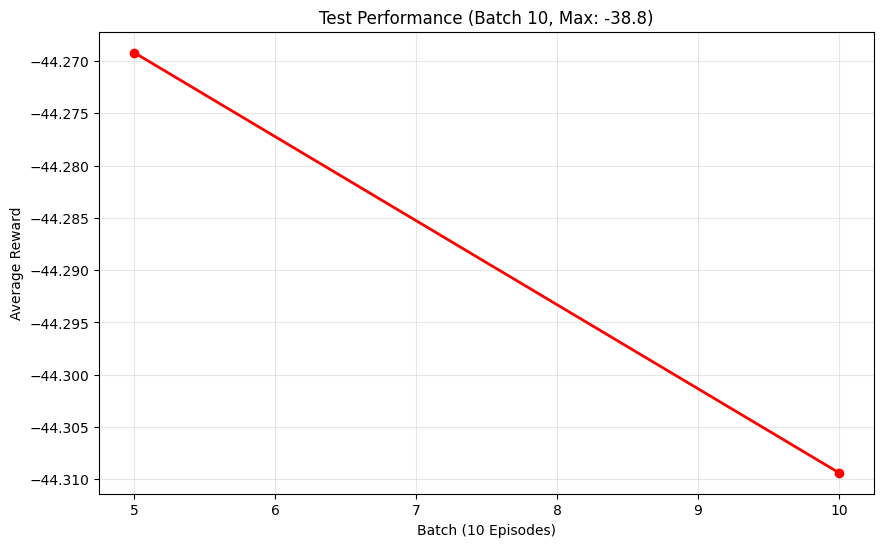

  1%|          | 12/1000 [01:09<1:29:40,  5.45s/it]

Training Batch 12: Collected 121 timesteps Episode Count: 10


  1%|▏         | 13/1000 [01:15<1:31:25,  5.56s/it]

Training Batch 13: Collected 113 timesteps Episode Count: 10


  1%|▏         | 14/1000 [01:19<1:24:12,  5.12s/it]

Training Batch 14: Collected 98 timesteps Episode Count: 10


  2%|▏         | 15/1000 [01:23<1:18:37,  4.79s/it]

Training Batch 15: Collected 94 timesteps Episode Count: 10
Training Batch 16: Collected 123 timesteps Episode Count: 10


  2%|▏         | 16/1000 [01:31<1:35:14,  5.81s/it]

Episode 15: Avg Test Reward = -45.80, Max Test Reward = -38.82


  2%|▏         | 17/1000 [01:36<1:29:25,  5.46s/it]

Training Batch 17: Collected 108 timesteps Episode Count: 10


  2%|▏         | 18/1000 [01:42<1:30:48,  5.55s/it]

Training Batch 18: Collected 117 timesteps Episode Count: 10


  2%|▏         | 19/1000 [01:46<1:24:21,  5.16s/it]

Training Batch 19: Collected 93 timesteps Episode Count: 10


  2%|▏         | 20/1000 [01:54<1:38:17,  6.02s/it]

Training Batch 20: Collected 123 timesteps Episode Count: 10


In [ ]:
rollout_size = 10

# Training loop
for batch in tqdm.tqdm(range(nb_batches)):

    # PPO Initialization
    advantages = torch.zeros(max_timesteps_per_rollout*rollout_size, dtype=torch.float32, device=device)
    buffer_states = torch.zeros((max_timesteps_per_rollout*rollout_size, state_dim), dtype=torch.float32, device=device)
    buffer_actions = torch.zeros((max_timesteps_per_rollout*rollout_size, action_dim), dtype=torch.float32, device=device)
    buffer_log_probs = torch.zeros((max_timesteps_per_rollout*rollout_size), dtype=torch.float32, device=device)
    buffer_state_values = torch.zeros((max_timesteps_per_rollout*rollout_size+1), dtype=torch.float32, device=device)
    buffer_rewards = torch.zeros((max_timesteps_per_rollout*rollout_size), dtype=torch.float32, device=device)
    buffer_is_terminal = torch.zeros((max_timesteps_per_rollout*rollout_size), dtype=torch.float32, device=device)

    # Env Initialization
    obs, _ = env.reset()
    state_manager.update(obs)

    # Initialize target_id
    target_id = env.unwrapped.vehicle.lane_index[-1]
    agent_state = state_manager.ego_state_agent(target_id=target_id)

    # Episode Reset
    obs, _ = env.reset()
    state_manager.update(obs)
    done = False
    obs_old = obs
    episode_step = 0
    episode_return = 0.0
    t = 0
    rollout = 0

    while not done and rollout < rollout_size:
      gap_control = Gap_Controller(obs, following_gap_threshold=30)
      activated_target_lane = gap_control.lane_checker()

      # Determine target lane
      target_id = activated_target_lane
      agent_state = state_manager.ego_state_agent(target_id=target_id)

      # Convert agent state dict to tensor
      state_tensor = torch.tensor(
          [agent_state[key] for key in ['vx', 'longitudinal_acceleration', 'x', 'y', 'thetha', 'lane_id', 'lane_width', 'self_curvature']],
          dtype=torch.float32, device=device
      ).unsqueeze(0)

      # Get action and value from model
      with torch.no_grad():
          agent_action, log_prob, value = model.action(state_tensor)
          action = state_manager.action(obs,agent_action)

      # Take action in environment
      obs, reward, done, truncated, info = env.step(action)
      done = done or truncated

      # Terminal conditions
      if info["crashed"] or not env.unwrapped.vehicle.on_road or t>=max_timesteps_per_rollout:
          done = True

      # Update state manager with new observation and applied longitudinal control
      state_manager.update(obs)

      # Compute reward based on the new state
      reward_components = state_manager.reward_function(obs_old, obs, target_id)
      reward = reward_components[0]

      # Store trajectory information
      buffer_states[t] = state_tensor.squeeze(0)
      buffer_actions[t] = agent_action
      buffer_log_probs[t] = log_prob
      buffer_state_values[t] = value
      buffer_rewards[t] = torch.tensor(reward, dtype=torch.float32, device=device)
      buffer_is_terminal[t] = done

      t += 1  # Increment timestep counter
      obs_old = obs

      # If episode is done, increment rollout and reset for next episode
      if done:
          rollout += 1
          if rollout < rollout_size:
              obs, _ = env.reset()
              state_manager.update(obs)
              done = False
              obs_old = obs

    # Print rollout info
    print(f"Training Batch {batch+1}: Collected {t} timesteps Episode Count: {rollout}")

    # Calculate advantages using GAE
    gae = 0
    advantages = torch.zeros(t, dtype=torch.float32, device=device)

    for t_idx in range(t-1, -1, -1):
        if buffer_is_terminal[t_idx]:
            terminal = 1
            next_value = 0
        else:
            terminal = 0
            if t_idx == t-1:
                next_value = 0
            else:
                next_value = buffer_state_values[t_idx+1]

        delta = buffer_rewards[t_idx] + gamma * next_value * (1-terminal) - buffer_state_values[t_idx]
        gae = delta + (gamma * gae_lambda) * gae * (1-terminal)
        advantages[t_idx] = gae

    # Prepare data for policy update
    advantages_data_loader = DataLoader(
        TensorDataset(
            advantages.detach(),
            buffer_states[:t].detach(),
            buffer_actions[:t].detach(),
            buffer_log_probs[:t].detach(),
            buffer_state_values[:t].detach()),
        batch_size=min(batch_size, t),
        shuffle=True)

    # Policy update (K epochs)
    for epoch in range(K):
        for batch_data in advantages_data_loader:
            b_adv, obs_batch, action_batch, old_log_probs, old_state_values = batch_data

            # Forward pass
            dist, value = model(obs_batch)
            log_probs = dist.log_prob(action_batch)

            # Calculate ratio
            ratio = torch.exp(log_probs - old_log_probs)
            returns = b_adv + old_state_values

            # Policy loss
            policy_loss_1 = b_adv * ratio
            policy_loss_2 = b_adv * torch.clamp(ratio, 1-epsilon, 1+epsilon)
            policy_loss = -torch.min(policy_loss_1, policy_loss_2).mean()

            actor_loss = policy_loss - ent_coef_c2 * dist.entropy().mean()
            critic_loss = F.mse_loss(value.squeeze(),returns)

            # Optimize
            # For the actor:
            actor_optimizer.zero_grad() # Clear gradients for actor
            actor_loss.backward()       # Compute gradients for actor_loss w.r.t. actor_params
            actor_optimizer.step()      # Update actor_params

            # For the critic:
            critic_optimizer.zero_grad() # Clear gradients for critic
            critic_loss.backward()       # Compute gradients for critic_loss w.r.t. critic_params
            critic_optimizer.step()

    # Testing every 5 batches
    if batch % test_rate == 0 and batch > 0:
        num_test = 1
        test_rewards = []

        for test_ep in range(10):  # 10 test episodes
            obs, _ = env.reset()
            obs_old = obs
            state_manager = ENV(obs,control_parameters=control_parameters,desired_parameters=desired_parameters)
            episode_reward = 0
            done = False
            test_steps = 0

            while not done and test_steps < 500:  # Limit test episode
                gap_control = Gap_Controller(obs, following_gap_threshold=30)
                activated_target_lane = gap_control.lane_checker()

                # Determine target lane
                target_id = activated_target_lane
                agent_state = state_manager.ego_state_agent(target_id=target_id)

                state_tensor = torch.tensor(
                    [agent_state[key] for key in ['vx', 'longitudinal_acceleration', 'x', 'y', 'thetha', 'lane_id', 'lane_width', 'self_curvature']],
                    dtype=torch.float32, device=device
                ).unsqueeze(0)

                with torch.no_grad():
                    agent_action, log_prob, value = model.action(state_tensor,deterministic=True)

                action = state_manager.action(obs, agent_action)

                obs, _, done, truncated, info = env.step(action)
                done = done or truncated

                # Terminal conditions
                if info["crashed"] or not env.unwrapped.vehicle.on_road or t>=max_timesteps_per_rollout:
                    done = True

                state_manager.update(obs)
                reward_components = state_manager.reward_function(obs_old, obs, target_id)
                reward = reward_components[0]

                episode_reward += reward
                test_steps += 1
                obs_old = obs

            test_rewards.append(episode_reward)

        avg_test_reward = sum(test_rewards) / len(test_rewards)
        current_max = max(test_rewards)

        if current_max > max_reward:
            max_reward = current_max

        batch_average_reward_history.append(avg_test_reward)
        batch_episode_history.append(batch)

        print(f"Episode {batch}: Avg Test Reward = {avg_test_reward:.2f}, Max Test Reward = {current_max:.2f}")

    # Plot every 50 btaches
    if batch % 10 == 0 and batch > 0 and len(batch_average_reward_history) > 0:
        plt.figure(figsize=(10, 6))
        plt.plot(batch_episode_history, batch_average_reward_history, 'r-o', linewidth=2)
        plt.title(f"Test Performance (Batch {batch}, Max: {max_reward:.1f})")
        plt.xlabel("Batch (10 Episodes)")
        plt.ylabel("Average Reward")
        plt.grid(True, alpha=0.3)
        plt.show()

print("Training completed!")